In [ ]:
%matplotlib inline
%load_ext watermark
%watermark -a 'Arttu Modig' -v -m -d -t -p numpy,pandas,seaborn,matplotlib,pystan,notebook

Arttu Modig 2017-12-04 17:32:41 

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
seaborn 0.8.1
matplotlib 2.1.0
pystan 2.16.0.1dev
notebook 5.2.2

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ab_testing.analysis import analyze_pairwise_grouped_data, hpd
from ab_testing.plotting import plot_ab_test_diff_of_means, plot_ab_test_mean_posteriors
from IPython.display import display

In [ ]:
#%env CC # might be important to set & check, if using other compilers

In [ ]:
%pwd

'/Users/amodig/git/veikkaus/ab_testing'

In [ ]:
data = pd.read_csv("data/data_sales_grouped.csv")
data.head()

group  revenue  count  label
0  control      0.0  38314      1
1  control      1.0   4596      1
2  control      1.1    118      1
3  control      1.2    245      1
4  control      1.3    155      1

In [ ]:
# run the most simple legacy model
results = analyze_pairwise_grouped_data(data, n_iterations=2000, stan_file="legacy_updated.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f519082f4b4edd54634dc888d825c23 NOW.


In [ ]:
results.keys()

dict_keys(['conversion_a', 'conversion_b', 'lognormal_mean_a', 'lognormal_mean_b', 'samples_total', 'summary', 'iter_total'])

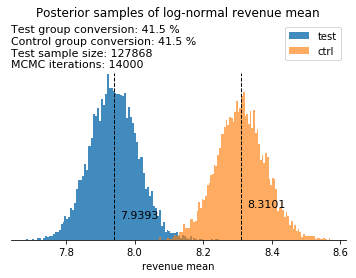

In [ ]:
fig, ax = plt.subplots()
ax = plot_ab_test_mean_posteriors(mean_a=results['lognormal_mean_a'],
                             mean_b=results['lognormal_mean_b'],
                             conversion_a=np.mean(results['conversion_a']),
                             conversion_b=np.mean(results['conversion_b']),
                             N=results['samples_total'],
                             iter=results['iter_total'],
                             ax=ax)

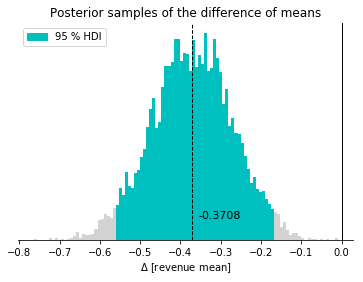

In [ ]:
fig, ax = plt.subplots()
ax = plot_ab_test_diff_of_means(mean_a=results['lognormal_mean_a'],
                                mean_b=results['lognormal_mean_b'])

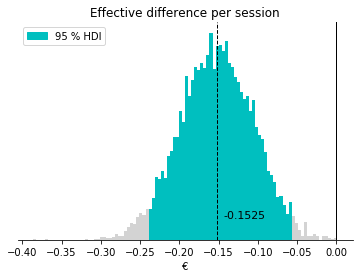

In [ ]:
# effective result per purchase
fig, ax = plt.subplots()
ax = plot_ab_test_diff_of_means(mean_a=results['conversion_a'] * results['lognormal_mean_a'],
                           mean_b=results['conversion_b'] * results['lognormal_mean_b'],
                           title="Effective difference per session",
                           xlabel="€")

In [ ]:
# Simple stopping rule. See the basic idea here:
# https://www.smartly.io/blog/statistical-significance-for-humans-automated-statistical-significance-calculator-for-a/b-testing

smallest_interesting_difference = 0.05  # 5 snt
alpha = 0.05

def evaluate_HDI(HDI, precision):
    if np.diff(HDI) > 2 * precision:
        print("Continue testing. ({a:.2f} > {b})".format(a=np.diff(HDI)[0],
                                                    b=2*precision))
    else:
        if np.prod(HDI) > 0:
            better, worse = ("A", "B") if HDI[0] > 0 else ("B", "A")
            print('Stop the test: {} is better than {}.'.format(better, worse))
        else:
            print('Stop the test: No difference found.')

diff = (results['conversion_b'] * results['lognormal_mean_b']
        - results['conversion_a'] * results['lognormal_mean_a'])
x = np.sort(diff)
a, b = hpd(x, alpha)

evaluate_HDI((a,b), 0.5 * smallest_interesting_difference)

Continue testing. (0.18 > 0.05)
